In [1]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt
from glob import glob
from os.path import dirname, abspath, join, exists

from clearml import Task, OutputModel

from amplify.data import DataGenerator, DataSplit

## Load Data

In [2]:
# DataGenerator - ClearML
xy_data = DataGenerator().load_data()
xy_data.shape

Info: Successfully loaded Building data!
Info: Successfully loaded Weather data!
Successfully merged Building and Weather data!
Successfully added Azimuth and Irradiance data!


(1994, 7)

## Data Processing

In [14]:
# ClearML Stuff
task = Task.init(project_name="amplify", task_name="encoder-decoder-lstm", output_uri="s3://amplify-microgrid-ai")

ClearML Task: created new task id=6e12aae971b8455d901fda1829a9556f
2022-02-01 23:55:20,681 - clearml.Task - INFO - No repository found, storing script code instead
ClearML results page: https://app.clear.ml/projects/f0e0b096252d4c18b9005e580afc5bce/experiments/6e12aae971b8455d901fda1829a9556f/output/log


In [15]:
# Data Split parameters 
SERIES = 48
STRIDE = 1

In [16]:
# Data Shape 
# Batch Size of 10
# Series of 7 Days 168
# (B,  S,   H, F) <-X Y-> (B,  S,   H, O)
# (20, 30, 48, 5) <-X Y-> (20, 30, 48, 1)

# |0| |2|3| |5|6|7|8|9|
#    T     V 

# This is for solar only, for now
train_ds, val_ds, test_ds = DataSplit(xy_data, series_length=SERIES, stride=STRIDE).split_data()

Successfully split data into (train_x, train_y), (val_x, val_y), (test_x, test_y) tuples!


In [17]:
# Isolate XY from datasets
x_train, y_train,  = (
    train_ds[0],
    train_ds[1],
)  # Training data
x_val, y_val = (
    val_ds[0],
    val_ds[1],
)  # Validation data
x_test, y_test = (
    test_ds[0],
    test_ds[1],
)  # Test data


### Reviewing Data

In [18]:
print("x_train shape: ", x_train.shape)
print("y_train shape: ", y_train.shape)


x_train shape:  (1547, 48, 5)
y_train shape:  (1547, 48, 2)


## Modeling

In [19]:
import tensorflow as tf
from keras.models import Model
from keras.layers import Input, LSTM, Dense, RepeatVector, Normalization, TimeDistributed

### Normalize Data

## Encoder/Decoder LSTM

In [20]:
# Normalize to x_train data
norm_layer = Normalization(axis=None)
norm_layer.adapt(x_train)

# Define the model 
norm_inputs = Input(shape=(SERIES, x_train.shape[-1]))
encoder_inputs = norm_layer(norm_inputs)
encoder_l1 = LSTM(10*SERIES, return_state=True, dropout=.25)
encoder_outputs1 = encoder_l1(encoder_inputs)

encoder_states1 = encoder_outputs1[1:]

decoder_inputs = RepeatVector(SERIES)(encoder_outputs1[0])

decoder_l1 = LSTM(10*SERIES, return_sequences=True)(decoder_inputs, initial_state = encoder_states1)
decoder_outputs1 = TimeDistributed(Dense(y_train.shape[-1], activation='relu'))(decoder_l1)

model = Model(norm_inputs, decoder_outputs1)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 48, 5)]      0           []                               
                                                                                                  
 normalization_1 (Normalization  (None, 48, 5)       3           ['input_2[0][0]']                
 )                                                                                                
                                                                                                  
 lstm_2 (LSTM)                  [(None, 480),        933120      ['normalization_1[0][0]']        
                                 (None, 480),                                                     
                                 (None, 480)]                                               

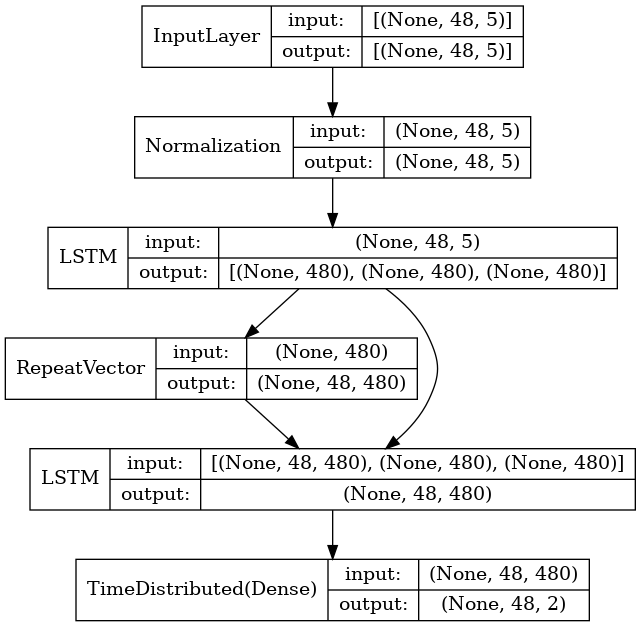

In [21]:
model.summary()
tf.keras.utils.plot_model(model, show_shapes=True, show_layer_names=False)

In [22]:
# Hyperparameters and callbacks

BATCH  = 1
EPOCHS = 100
LRATE = .001
FACTOR = .9
PATIENCE = 2

log_dir = os.path.join('../','logs')
model_path = os.path.join('../', 'models', "lstm_weights.hdf5")

callbacks = [
    tf.keras.callbacks.TensorBoard(log_dir),
    tf.keras.callbacks.ModelCheckpoint(
        model_path, 
        monitor="val_loss",
        mode='min',
        save_best_only=True, 
        save_weights_only=True, 
        verbose=1),
    tf.keras.callbacks.ReduceLROnPlateau(
        monitor='val_loss', 
        mode='min', 
        factor=FACTOR,
        patience=PATIENCE, 
        min_lr=1e-4, 
        verbose=0),
    tf.keras.callbacks.EarlyStopping(
        monitor="val_loss",
        mode='min', 
        patience=EPOCHS*BATCH/5, 
        verbose=1)
]

In [23]:
# try:
#     model.load_weights(model_path)
# except Exception:
#     pass

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LRATE), 
    #loss=tf.keras.losses.Huber(), # Less sensitive to outliers 
    loss=tf.keras.losses.MeanSquaredError(),  # More sensitive to outliers 
    metrics=[tf.keras.metrics.RootMeanSquaredError()])
    
history = model.fit(
    x=x_train,
    y=y_train,
    epochs=EPOCHS,
    batch_size=BATCH,
    shuffle=True,
    validation_data=(x_test, y_test), ### <---- fix val data
    callbacks=callbacks
)

Epoch 1/100
1544/1547 [============================>.] - ETA: 0s - loss: 64.7152 - root_mean_squared_error: 8.0446
Epoch 00001: val_loss improved from inf to 44.28122, saving model to ../models/lstm_weights.hdf5
2022-02-01 23:55:45,220 - clearml.storage - INFO - Starting upload: /tmp/.clearml.upload_model_1_jkm9gh.tmp => amplify-microgrid-ai/amplify/encoder-decoder-lstm.6e12aae971b8455d901fda1829a9556f/models/lstm_weights.hdf5
1547/1547 [==============================] - 21s 12ms/step - loss: 64.7185 - root_mean_squared_error: 8.0448 - val_loss: 44.2812 - val_root_mean_squared_error: 6.6544 - lr: 0.0010
Epoch 2/100
1544/1547 [============================>.] - ETA: 0s - loss: 61.7793 - root_mean_squared_error: 7.8600
Epoch 00002: val_loss improved from 44.28122 to 42.18879, saving model to ../models/lstm_weights.hdf5
2022-02-01 23:56:03,338 - clearml.storage - INFO - Starting upload: /tmp/.clearml.upload_model_7tm7xqxx.tmp => amplify-microgrid-ai/amplify/encoder-decoder-lstm.6e12aae971b

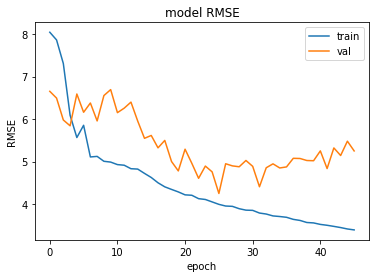

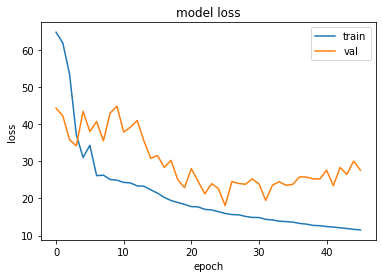

In [24]:
def plot_history(history, metric):
    # This function will plot the model fit process
    # summarize history for accuracy
    if metric == "root_mean_squared_error":
        plt.plot(history.history['root_mean_squared_error'])
        plt.plot(history.history['val_root_mean_squared_error'])
        plt.title('model RMSE')
        plt.ylabel('RMSE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    elif metric == "mean_absolute_percentage_error":
        plt.plot(history.history["mean_absolute_percentage_error"])
        plt.plot(history.history["val_mean_absolute_percentage_error"])
        plt.title('model MAPE')
        plt.ylabel('MAPE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    elif metric == "mean_absolute_error":
        plt.plot(history.history["mean_absolute_error"])
        plt.plot(history.history["val_mean_absolute_error"])
        plt.title('model MAE')
        plt.ylabel('MAE')
        plt.xlabel('epoch')
        plt.legend(['train', 'val'], loc='upper right')
        plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper right')
    plt.show()

plot_history(history, 'root_mean_squared_error')

In [59]:
# Evaluate and make predictions
model.load_weights(model_path)
scores = model.evaluate(x_val, y_val, verbose=1, batch_size=BATCH, callbacks=callbacks)
scores = model.evaluate(x_test, y_test, verbose=1, batch_size=BATCH, callbacks=callbacks)
y_preds = model.predict(x_test, verbose=1, batch_size=BATCH, callbacks=callbacks)


2022-02-02 00:10:52,293 - clearml.Task - ERROR - Action failed <400/110: tasks.add_or_update_model/v2.13 (Invalid task status: expected=created, status=completed)> (task=6e12aae971b8455d901fda1829a9556f, name=lstm_weights, model=bc687acd7cf14304ba1e91f3b8931b08, type=input)
151/151 [==============================] - 1s 4ms/step


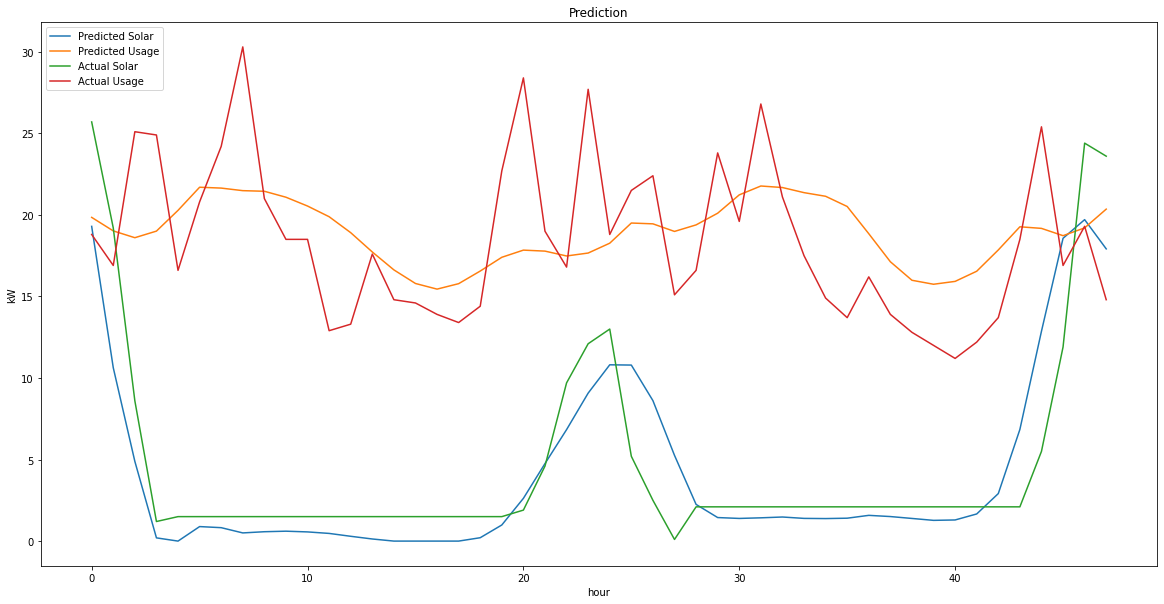

In [67]:
plt.figure(figsize=(20, 10))
plt.title('Prediction')
x = np.random.default_rng().integers(0, y_preds.shape[0])
plt.plot(y_preds[x,:,:])
plt.plot(y_test[x,:,:])
plt.ylabel('kW')
plt.xlabel('hour')
plt.legend(['Predicted Solar', 'Predicted Usage', 'Actual Solar', 'Actual Usage'], loc='upper left')

plt.show()

In [27]:
task.close()